In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data
import torchvision

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image

import pandas as pd
import numpy as np
import scipy.io
import skimage.io

from PIL import Image, ImageFilter

from tensorboardX import SummaryWriter
import tqdm

In [2]:
# # count the number of pixels in each affordance
# import glob

# path_list = glob.glob('./part-affordance-dataset/tools/*', recursive=True)

In [3]:
# image_path_list_train = []
# image_path_list_train_with_label = []
# image_path_list_train_without_label = []
# image_path_list_test = []

# for path in path_list:
#     i = glob.glob(path + '/*rgb.jpg')
    
#     image_path_list_test += i[:50]
#     image_path_list_train += i[50:]

# for i, path in enumerate(image_path_list_train):
#     if i%2 == 0:
#         image_path_list_train_with_label.append(path)
#     else:
#         image_path_list_train_without_label.append(path)

In [6]:
# class_path_list_train_with_label = []
# class_path_list_test = []

# for path in image_path_list_train_with_label:
#     c = path[:-7] + 'label.mat'
#     class_path_list_train_with_label.append(c)
    
# for path in image_path_list_test:
#     c = path[:-7] + 'label.mat'
#     class_path_list_test.append(c)

In [7]:
# df_train_with_label = pd.DataFrame({
#     "image_path": image_path_list_train_with_label,
#     "class_path": class_path_list_train_with_label},
#     columns=["image_path", "class_path"]
# )

In [9]:
# df_train_without_label = pd.DataFrame({
#     "image_path": image_path_list_train_without_label
# })

In [11]:
# df_test = pd.DataFrame({
#     "image_path": image_path_list_test,
#     "class_path": class_path_list_test},
#     columns=["image_path", "class_path"]
# )

In [13]:
# df_train_with_label.to_csv('train_with_label.csv', index=None)
# df_train_without_label.to_csv('train_without_label.csv', index=None)
# df_test.to_csv('test.csv', index=None)

# Dataset Class

In [2]:
class PartAffordanceDataset(Dataset):
    """Part Affordance Dataset"""
    
    def __init__(self, csv_file, transform=None):
        super().__init__()
        
        self.image_class_path = pd.read_csv(csv_file)
        self.transform = transform
        
    def __len__(self):
        return len(self.image_class_path)
    
    def __getitem__(self, idx):
        image_path = self.image_class_path.iloc[idx, 0]
        class_path = self.image_class_path.iloc[idx, 1]
        image = skimage.io.imread(image_path) # read as numpy array
        cls = scipy.io.loadmat(class_path)["gt_label"]
        
        sample = {'image': image, 'class': cls}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

In [3]:
class PartAffordanceDatasetWithoutLabel(Dataset):
    """Part Affordance Dataset"""
    
    def __init__(self, csv_file, transform=None):
        super().__init__()
        
        self.image_class_path = pd.read_csv(csv_file)
        self.transform = transform
        
    def __len__(self):
        return len(self.image_class_path)
    
    def __getitem__(self, idx):
        image_path = self.image_class_path.iloc[idx]
        image = skimage.io.imread(image_path) # read as numpy array
        
        if self.transform:
            image = self.transform(image)
            
        return image

In [4]:
def crop_center_numpy(array, crop_height, crop_weight):
    h, w = array.shape
    return array[h//2 - crop_height//2: h//2 + crop_height//2,
                 w//2 - crop_weight//2: w//2 + crop_weight//2
                ]

In [5]:
def crop_center_pil_image(pil_img, crop_width, crop_height):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

In [6]:
class CenterCrop(object):
    def __call__(self, sample):
        image, cls = sample['image'], sample['class']
        
        image = Image.fromarray(np.uint8(image))
        
        image = crop_center_pil_image(image, 320, 320)
        cls = crop_center_numpy(cls, 320, 320)
        
        return {'image': image, 'class': cls}

In [7]:
def nn_interpolate(array, new_size):
    ''' nearest neighbor interpolation '''
    
    new_array = np.zeros(new_size)
    old_size = array.shape
    ratio = new_size[0] / old_size[0], new_size[1] / old_size[1]
    
    for i in range(new_size[0]):
        for j in range(new_size[1]):
            new_array[i][j] = array[int(np.round(i/ratio[0]))][int(np.round(j/ratio[1]))]
            
    return new_array

In [12]:
class Resize(object):
    ''' Resize the images and labels '''
    
    def __call__(self, sample):
        image, cls = sample['image'], sample['class']
        
        image = transforms.functional.resize(image, (224, 224)) # input size of ResNet is (224, 224)
        cls = nn_interpolate(cls, (224, 224))
        
        image = np.asarray(image)
        
        return {'image': image, 'class': cls}

In [13]:
class ToTensor(object):
    def __call__(self, sample):
        image, cls = sample['image'], sample['class']
        
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image).float(), 
                'class': torch.from_numpy(cls).long()}

In [14]:
# data = PartAffordanceDataset('image_class_path.csv',
#                                 transform=transforms.Compose([
#                                     CenterCrop(),
#                                     ToTensor()
#                                 ]))

# data_loader = DataLoader(data, batch_size=10, shuffle=False)

# mean = 0
# std = 0
# n = 0

# for sample in data_loader:
#     img = sample['image']   
#     img = img.view(len(img), 3, -1)
#     mean += img.mean(2).sum(0)
#     std += img.std(2).sum(0)
#     n += len(img)
    
# mean /= n
# std /= n

In [15]:
mean=[55.8630, 59.9099, 91.7419]
std=[31.6852, 29.8496, 19.0835]

In [16]:
class Normalize(object):
    def __call__(self, sample):
        image, cls = sample['image'], sample['class']
        
        image = transforms.functional.normalize(image, mean, std)
        
        return {'image': image, 'class': cls}

In [18]:
train_data_with_label = PartAffordanceDataset('train_with_label.csv',
                                            transform=transforms.Compose([
                                                CenterCrop(),
                                                Resize(),
                                                ToTensor(),
                                                Normalize()
                                            ]))

train_data_without_label = PartAffordanceDatasetWithoutLabel('train_with_label.csv',
                                            transform=transforms.Compose([
                                                CenterCrop(),
                                                Resize(),
                                                ToTensor(),
                                                Normalize()
                                ]))

In [19]:
test_data = PartAffordanceDataset('test.csv',
                                transform=transforms.Compose([
                                    CenterCrop(),
                                    Resize(),
                                    ToTensor(),
                                    Normalize()
                                ]))

In [20]:
train_loader_with_label = DataLoader(train_data_with_label, batch_size=1, shuffle=True)
test_loader_without_label = DataLoader(train_data_without_label, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [107]:
for sample in train_loader:
    i = sample['image']
    l = sample['class'].numpy()
    i = i.view(3, 320, 320)
    i = transforms.functional.to_pil_image(i)
    i = transforms.functional.resize(i, (224, 224))
    l1 = class_to_mask(l)
    l = nn_interpolate(l, (224, 224))
    l2 = class_to_mask(l)
    break

RuntimeError: Dimension out of range (expected to be in range of [-3, 2], but got 3)

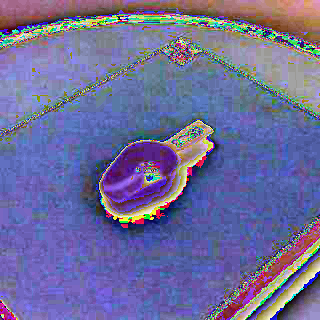

In [91]:
i

# the number of pixels in each class after center crop

In [122]:
# dataset = PartAffordanceDataset('image_class_path.csv',
#                                 transform=transforms.Compose([
#                                     CenterCrop(),
#                                     ToTensor()
#                                 ]))
# data_laoder = DataLoader(dataset, batch_size=100, shuffle=False)

# cnt_dict = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0}

# for sample in data_laoder:
#     img = sample['class'].numpy()
    
#     num, cnt = np.unique(img, return_counts=True)
    
#     for n, c in zip(num, cnt):
#         cnt_dict[n] += c

0: 2078085712,  
 1: 34078992,  
 2: 15921090,  
 3: 12433420,  
 4: 38473752,  
 5: 6773528,  
 6: 9273826,  
 7: 20102080  

# Define Network

## Segmentation Network

In [21]:
resnet = torchvision.models.resnet101(pretrained=True)

In [22]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [23]:
mode  = nn.Sequential(*list(resnet.children())[:-2])

In [24]:
print(mode)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1

In [30]:
class ASPP(nn.Module):
    """ Atrous Spatial Pyramid Pooling """
    
    def __init__(self, in_channel, out_channel, pyramids):
        super().__init__()
        
        self.atrous_convs = nn.Module()
        
        for i, p in enumerate(pyramids):
            self.atrous_convs.add_module(
                "atrous_conv{}".format(i),
                nn.Conv2d(in_channel, out_channel, 3, 1, padding=p, dilation=p, bias=True)
            )
        
        for m in self.atrous_convs.children():
            torch.nn.init.xavier_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)
            
    def forward(self, x):
        h = 0
        for atrous_conv in self.atrous_convs.children():
            h += atrous_conv(x)
        return h

In [39]:
class DeepLabV2(nn.Module):
    ''' ResNet => ASPP '''
    
    def __init__(self, in_channel, n_classes, pyramids):
        super().__init__()
        
        resnet = torchvision.models.resnet101(pretrained=True)
        self.resnet = nn.Sequential(*list(resnet.children())[:-2])
        self.aspp = ASPP(2048, n_classes, pyramids)
    
    def forward(self, x):
        x = self.resnet(x)
        print(x.shape)
        x = self.aspp(x)
        return x

In [40]:
x = torch.ones(1,3,224,224)

In [41]:
model = DeepLabV2(3, 8, [6, 12, 18, 24])

In [42]:
y = model(x)

torch.Size([1, 2048, 7, 7])


In [43]:
print(y.shape)

torch.Size([1, 8, 7, 7])


# class_weigh

In [5]:
class_num = torch.tensor([2078085712, 34078992, 15921090, 12433420, 
                          38473752, 6773528, 9273826, 20102080])

total = class_num.sum().item()

frequency = class_num.float() / total
median = torch.median(frequency)

class_weight = median / frequency

# Training

In [ ]:
def eval_model(model, test_loader, device='cpu'):
    model.eval()
    
    intersection = torch.zeros(8)   # the dataset has 8 classes including background
    union = torch.zeros(8)
    
    for sample in test_loader:
        x, y = sample['image'], sample['class']
        
        x = x.to(device)
        y = y.to(device)
        
        with torch.no_grad():
            _, ypred = model(x).max(1)    # y_pred.shape => (N, 240, 320)
        
        for i in range(8):
            y_i = (y == i)           
            ypred_i = (ypred == i)   
            
            inter = (y_i.byte() & ypred_i.byte()).float().sum().to('cpu')
            intersection[i] += inter
            union[i] += (y_i.float().sum() + ypred_i.float().sum()).to('cpu') - inter
    
    """ iou[i] is the IoU of class i """
    iou = intersection / union
    
    return iou

In [ ]:
def train_model(model, train_loader, test_loader, optimizer_cls=optim.Adam, 
                criterion=nn.CrossEntropyLoss(), max_epoch=200, device='cpu', writer=None):
    
    model.to(device)
    
    train_losses = []
    val_iou = []
    mean_iou = []
    best_iou = 0.0
    
    optimizer = optimizer_cls(model.parameters(), lr=0.01)
    
    for epoch in range(max_epoch):
        model.train()
        running_loss = 0.0
        
        for i, sample in tqdm.tqdm(enumerate(train_loader), total=len(train_loader)):
            optimizer.zero_grad()
            
            x, y = sample['image'], sample['class']
            
            x = x.to(device)
            y = y.to(device)

            h = model(x)
            loss = criterion(h, y)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        train_losses.append(running_loss / i)
        
        val_iou.append(eval_model(model, test_loader, device))
        mean_iou.append(val_iou[-1].mean().item())
        
        if best_iou < mean_iou[-1]:
            best_iou = mean_iou[-1]
            torch.save(model.state_dict(), "./SegNet_with_class_weight(median)_results/best_iou_model.prm")
        
        if writer is not None:
            writer.add_scalar("train_loss", train_losses[-1], epoch)
            writer.add_scalar("mean_IoU", mean_iou[-1], epoch)
            writer.add_scalars("class_IoU", {'iou of class 0': val_iou[-1][0],
                                           'iou of class 1': val_iou[-1][1],
                                           'iou of class 2': val_iou[-1][2],
                                           'iou of class 3': val_iou[-1][3],
                                           'iou of class 4': val_iou[-1][4],
                                           'iou of class 5': val_iou[-1][5],
                                           'iou of class 6': val_iou[-1][6],
                                           'iou of class 7': val_iou[-1][7]}, epoch)
            
        print(epoch, train_losses[-1], mean_iou[-1])
        
    torch.save(model.state_dict(), "./SegNet_with_class_weight(median)_results/final_model.prm")

In [ ]:
# model = SegNetBasic(3, 8)
# writer = SummaryWriter("./SegNet_with_class_weight(median)_results/")
# train_model(model, train_loader, test_loader, criterion=nn.CrossEntropyLoss(weight=class_weight.to('cuda')), device="cuda", writer=writer)

In [103]:
colors = torch.tensor([[0, 0, 0],         # class 0 'background'  black
                       [255, 0, 0],       # class 1 'grasp'       red
                       [255, 255, 0],     # class 2 'cut'         yellow
                       [0, 255, 0],       # class 3 'scoop'       green
                       [0, 255, 255],     # class 4 'contain'     sky blue
                       [0, 0, 255],       # class 5 'pound'       blue
                       [255, 0, 255],     # class 6 'support'     purple
                       [255, 255, 255]    # class 7 'wrap grasp'  white
                      ])

In [104]:
def class_to_mask(cls):
    
    mask = colors[cls].transpose(1, 2).transpose(1, 3)
    
    return mask

In [ ]:
def predict(model, sample, device='cpu'):
    model.eval()
    model.to(device)
    
    x, y = sample['image'], sample['class']
    
    x = x.to(device)
    y = y.to(device)

    with torch.no_grad():
        _, y_pred = model(x).max(1)    # y_pred.shape => (N, 240, 320)
    
    true_mask = class_to_mask(y).to('cpu')
    pred_mask = class_to_mask(y_pred).to('cpu')
    
    save_image(x.to('cpu'), "./original_img_with_SegNet.jpg")
    save_image(true_mask, "./true_mask_with_SegNet.jpg")
    save_image(pred_mask, "./pred_mask_with_SegNet.jpg")

In [ ]:
trained_model = SegNetBasic(3, 8)
trained_model.load_state_dict(torch.load("./SegNet_with_class_weights_results/final_model.prm"))